Inference and Validation
Now that you have a trained network, you can use it for making predictions. This is typically called inference, a term borrowed from statistics. However, neural networks have a tendency to perform too well on the training data and aren't able to generalize to data that hasn't been seen before. This is called overfitting and it impairs inference performance.



To test for overfitting while training, we measure the performance on data not in the training set called the validation set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch.

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting train=False here:

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

100%|█████████████████████████████████████████████████████████████████▉| 26411008/26421880 [00:20<00:00, 503261.90it/s]

Extracting C:\Users\akash/.pytorch/F_MNIST_data/FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\Users\akash/.pytorch/F_MNIST_data/FashionMNIST\raw



0it [00:00, ?it/s]
 56%|████████████████████████████████████████▌                                | 16384/29515 [00:00<00:00, 81673.65it/s]
32768it [00:00, 41709.25it/s]                                                                                          

Extracting C:\Users\akash/.pytorch/F_MNIST_data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\akash/.pytorch/F_MNIST_data/FashionMNIST\raw



0it [00:00, ?it/s]
 97%|█████████████████████████████████████████████████████████████████▎ | 4308992/4422102 [00:04<00:00, 1266489.34it/s]
4423680it [00:04, 966717.27it/s]                                                                                       

Extracting C:\Users\akash/.pytorch/F_MNIST_data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\akash/.pytorch/F_MNIST_data/FashionMNIST\raw



0it [00:00, ?it/s]
  0%|                                                                                         | 0/5148 [00:00<?, ?it/s]
8192it [00:00, 18182.26it/s]                                                                                           

Extracting C:\Users\akash/.pytorch/F_MNIST_data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\akash/.pytorch/F_MNIST_data/FashionMNIST\raw
Processing...
Done!


In [2]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [3]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


26427392it [00:40, 503261.90it/s]                                                                                      

With the probabilities, we can get the most likely class using the ps.topk method.
This returns the  𝑘  highest values. Since we just want the most likely class, we can use ps.topk(1).
This returns a tuple of the top- 𝑘  values and the top- 𝑘  indices. If the highest value is the fifth element, 
we'll get back 4 as the index.

In [8]:

top_p, top_class = ps.topk(1, dim=1)
print(top_p.shape)
print(top_class.shape)
# Look at the most likely classes for the first 10 examples
print(top_p[:10,:])
print(top_class[:10,:])

torch.Size([64, 1])
torch.Size([64, 1])
tensor([[0.1192],
        [0.1231],
        [0.1226],
        [0.1229],
        [0.1229],
        [0.1233],
        [0.1213],
        [0.1247],
        [0.1211],
        [0.1236]], grad_fn=<SliceBackward>)
tensor([[8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8]])


Now we can check if the predicted classes match the labels. This is simple to do by equating top_class and labels, but we have to be careful of the shapes. Here top_class is a 2D tensor with shape (64, 1) while labels is 1D with shape (64). To get the equality to work out the way we want, top_class and labels must have the same shape.

If we do

equals = top_class == labels
equals will have shape (64, 64), try it yourself. What it's doing is comparing the one element in each row of top_class with each element in labels which returns 64 True/False boolean values for each row.

In [18]:
a=labels.view(*top_class.shape)
a

tensor([[7],
        [3],
        [1],
        [6],
        [1],
        [4],
        [7],
        [3],
        [7],
        [9],
        [4],
        [5],
        [3],
        [4],
        [3],
        [5],
        [3],
        [6],
        [5],
        [9],
        [3],
        [1],
        [3],
        [0],
        [5],
        [8],
        [1],
        [2],
        [2],
        [1],
        [1],
        [0],
        [9],
        [9],
        [4],
        [8],
        [8],
        [6],
        [6],
        [2],
        [1],
        [1],
        [6],
        [6],
        [3],
        [8],
        [6],
        [9],
        [8],
        [1],
        [1],
        [1],
        [8],
        [5],
        [3],
        [2],
        [5],
        [3],
        [6],
        [7],
        [6],
        [8],
        [2],
        [0]])

In [19]:
top_class

tensor([[8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8]])

In [9]:
equals = top_class == labels.view(*top_class.shape)

In [20]:
equals.shape

torch.Size([64, 1])

Now we need to calculate the percentage of correct predictions. equals has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to torch.mean. If only it was that simple. If you try torch.mean(equals), you'll get an error

RuntimeError: mean is not implemented for type torch.ByteTensor
This happens because equals has type torch.ByteTensor but torch.mean isn't implement for tensors with that type. So we'll need to convert equals to a float tensor. Note that when we take torch.mean it returns a scalar tensor, to get the actual value as a float we'll need to do accuracy.item().

In [21]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(accuracy)
print(accuracy.type)
print(f'Accuracy: {accuracy.item()*100}%')

tensor(0.1094)
<built-in method type of Tensor object at 0x0000023C97B2A6C0>
Accuracy: 10.9375%


In [22]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.508..  Test Loss: 0.459..  Test Accuracy: 0.836
Epoch: 2/30..  Training Loss: 0.392..  Test Loss: 0.409..  Test Accuracy: 0.850
Epoch: 3/30..  Training Loss: 0.355..  Test Loss: 0.407..  Test Accuracy: 0.856
Epoch: 4/30..  Training Loss: 0.334..  Test Loss: 0.373..  Test Accuracy: 0.872
Epoch: 5/30..  Training Loss: 0.317..  Test Loss: 0.380..  Test Accuracy: 0.868
Epoch: 6/30..  Training Loss: 0.304..  Test Loss: 0.390..  Test Accuracy: 0.865
Epoch: 7/30..  Training Loss: 0.290..  Test Loss: 0.379..  Test Accuracy: 0.873
Epoch: 8/30..  Training Loss: 0.285..  Test Loss: 0.361..  Test Accuracy: 0.875
Epoch: 9/30..  Training Loss: 0.275..  Test Loss: 0.412..  Test Accuracy: 0.865
Epoch: 10/30..  Training Loss: 0.269..  Test Loss: 0.357..  Test Accuracy: 0.880
Epoch: 11/30..  Training Loss: 0.261..  Test Loss: 0.364..  Test Accuracy: 0.875
Epoch: 12/30..  Training Loss: 0.253..  Test Loss: 0.373..  Test Accuracy: 0.877
Epoch: 13/30..  Training Loss: 0.245.

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

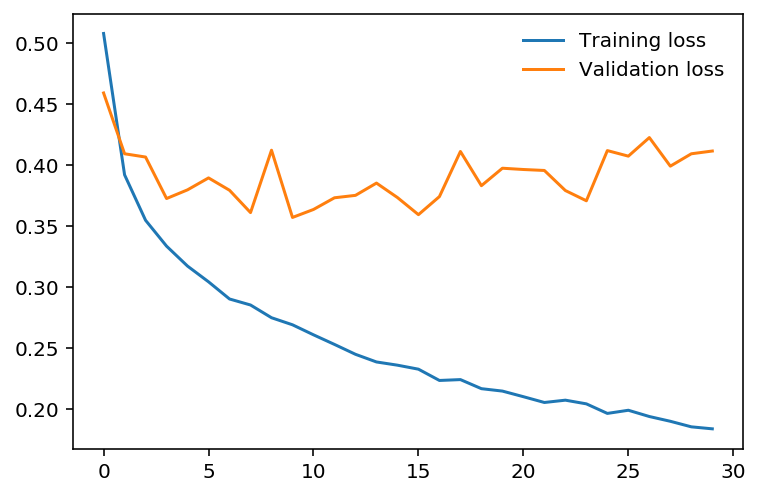

In [24]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called early-stopping. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is dropout, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the nn.Dropout module.

In [25]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

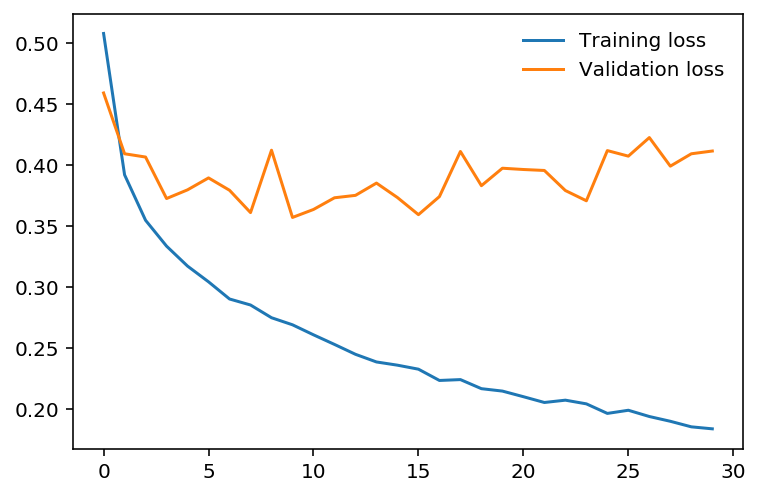

In [27]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

Inference
Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with model.eval(). You'll also want to turn off autograd with the torch.no_grad() context.

In [31]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)



In [32]:
ps = torch.exp(output)
top_p, top_class = ps.topk(1, dim=1)
equals = top_class == labels[0].view(*top_class.shape)

In [33]:
equalsS

tensor([[True]])